In [1]:
import pandas as pd
from pmdarima.arima import auto_arima

#85 percent train 15 percent test

In [2]:
df = pd.read_csv('variable_selected_county_dataset.csv', index_col=0)


In [64]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]


def difference(df):
    df['incremental_cases'] = df['incremental_cases'].diff().fillna(df['incremental_cases'])
    return df


nyc = data[data['entity'] == 'New York-Nassau'].loc[:, ['date', 'incremental_cases']]
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# NYC data is stationary without any differencing
stationary_test(train.incremental_cases)

(-3.5631021476017817, 0.006506904294634441)

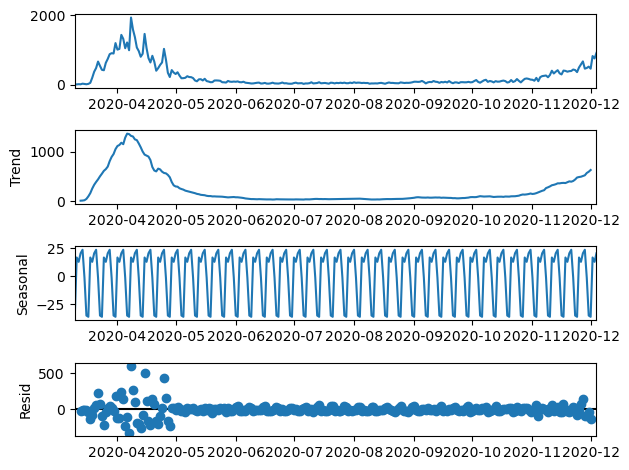

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

analysis = nyc.set_index('date').copy()


decompose_result_mult = seasonal_decompose(analysis)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [5]:
for x in decompose_result_mult.seasonal:
    print(x)

-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.72444625076203

In [72]:
arimaModel = nyc[['date', 'incremental_cases']]
train = arimaModel.head(int(0.85*len(arimaModel))+1)
test = arimaModel.tail(int(0.15*len(arimaModel)))

In [22]:
train

,date,incremental_cases
1620,2020-03-10,2
1621,2020-03-11,9
1622,2020-03-12,13
1623,2020-03-13,10
1624,2020-03-14,28
...,...,...
1845,2020-10-21,133
1846,2020-10-22,77
1847,2020-10-23,101
1848,2020-10-24,161


In [7]:
import statsmodels.api as sm

In [66]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [1, 3,5,10]
q_values = [1,3 ,5, 10]

P_values = [1, 3,5,10]
Q_values = [1,3, 5, 10]


best_score, best_cfg = float("inf"), None


for p in p_values:
    for q in q_values:
        for P in P_values:
            for Q in Q_values:
                order = (p, q, P, Q)
                print(order)
                avg = 0
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]

                    try:
                        model=auto_arima(y=train_data['incremental_cases'],max_q=q,max_Q=Q,
                                         max_p=p, max_P=P,d=2).fit(train_data['incremental_cases'])
                    except:
                        continue

                    forecast = model.predict(val_data.shape[0])
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    avg += mse
                if avg < best_score:
                    best_score, best_cfg = mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

(1, 1, 1, 1)
(1, 1, 1, 3)
(1, 1, 1, 5)
(1, 1, 1, 10)
(1, 1, 3, 1)
(1, 1, 3, 3)
(1, 1, 3, 5)
(1, 1, 3, 10)
(1, 1, 5, 1)
(1, 1, 5, 3)
(1, 1, 5, 5)
(1, 1, 5, 10)
(1, 1, 10, 1)
(1, 1, 10, 3)
(1, 1, 10, 5)
(1, 1, 10, 10)
(1, 3, 1, 1)
(1, 3, 1, 3)
(1, 3, 1, 5)
(1, 3, 1, 10)
(1, 3, 3, 1)
(1, 3, 3, 3)
(1, 3, 3, 5)
(1, 3, 3, 10)
(1, 3, 5, 1)
(1, 3, 5, 3)
(1, 3, 5, 5)
(1, 3, 5, 10)
(1, 3, 10, 1)
(1, 3, 10, 3)
(1, 3, 10, 5)
(1, 3, 10, 10)
(1, 5, 1, 1)
(1, 5, 1, 3)
(1, 5, 1, 5)
(1, 5, 1, 10)
(1, 5, 3, 1)
(1, 5, 3, 3)
(1, 5, 3, 5)
(1, 5, 3, 10)
(1, 5, 5, 1)
(1, 5, 5, 3)
(1, 5, 5, 5)
(1, 5, 5, 10)
(1, 5, 10, 1)
(1, 5, 10, 3)
(1, 5, 10, 5)
(1, 5, 10, 10)
(1, 10, 1, 1)
(1, 10, 1, 3)
(1, 10, 1, 5)
(1, 10, 1, 10)
(1, 10, 3, 1)
(1, 10, 3, 3)
(1, 10, 3, 5)
(1, 10, 3, 10)
(1, 10, 5, 1)
(1, 10, 5, 3)
(1, 10, 5, 5)
(1, 10, 5, 10)
(1, 10, 10, 1)
(1, 10, 10, 3)
(1, 10, 10, 5)
(1, 10, 10, 10)
(3, 1, 1, 1)
(3, 1, 1, 3)
(3, 1, 1, 5)
(3, 1, 1, 10)
(3, 1, 3, 1)
(3, 1, 3, 3)
(3, 1, 3, 5)
(3, 1, 3, 10)
(3, 1, 5, 1)
(

-0.5004189736578881


<AxesSubplot:xlabel='date'>

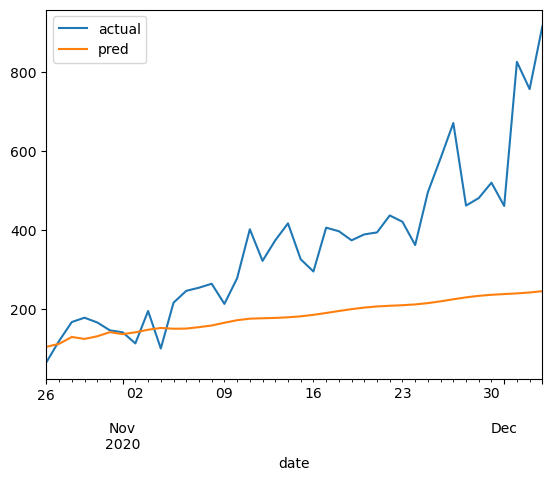

In [74]:
model=auto_arima(y=train['incremental_cases'],max_q=10,max_Q=10,
                                         max_p=10, max_P=10,d=2).fit(train['incremental_cases'])
pred = model.predict(40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

<AxesSubplot:xlabel='date'>

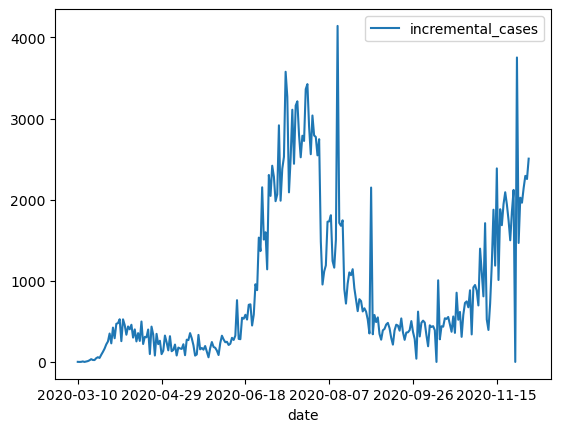

In [77]:
# get selected counties
miami = df[df.entity == 'Florida-Miami-Dade']
miami = miami[['date', 'incremental_cases']]
#miami.reset_index(inplace=True)
miami.plot(x='date', y='incremental_cases')


In [78]:
#need to differentiate twice to not be stationary
diffDf = miami.set_index('date')

statDF = diffDf.diff().diff()
firstVal = diffDf.diff(1).iloc[1,:].incremental_cases
firstDiff = diffDf.diff()

split = int(0.85 * len(statDF))
train = statDF.iloc[:split,:]
test = statDF.iloc[split:, :]
compareTest = diffDf.iloc[split:, :]

def fromTestDiffToActualInc(test, firstVal, secondVal):
    test.iloc[0,0] += firstVal
    test = test.cumsum()
    test.iloc[0,0] += secondVal
    return test.cumsum()

In [68]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index()
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [1,5,10]
q_values = [1,5,10]

P_values = [1,5,10]
Q_values = [1,5,10]


best_score, best_cfg = float("inf"), None

for p in p_values:
    for q in q_values:
        for P in P_values:
            for Q in Q_values:
                order = (p, q, P, Q)
                print(order)
                avg = 0
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]

                    try:
                        model=auto_arima(y=train_data['incremental_cases'],max_q=q,max_Q=Q,
                                         max_p=p, max_P=P,d=2).fit(train_data['incremental_cases'])
                    except:
                        continue

                    forecast = model.predict(val_data.shape[0])
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    avg += mse
                if avg < best_score:
                    best_score, best_cfg = mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

(1, 1, 1, 1)
(1, 1, 1, 5)
(1, 1, 1, 10)
(1, 1, 5, 1)
(1, 1, 5, 5)
(1, 1, 5, 10)
(1, 1, 10, 1)
(1, 1, 10, 5)
(1, 1, 10, 10)
(1, 5, 1, 1)
(1, 5, 1, 5)
(1, 5, 1, 10)
(1, 5, 5, 1)
(1, 5, 5, 5)
(1, 5, 5, 10)
(1, 5, 10, 1)
(1, 5, 10, 5)
(1, 5, 10, 10)
(1, 10, 1, 1)
(1, 10, 1, 5)
(1, 10, 1, 10)
(1, 10, 5, 1)
(1, 10, 5, 5)
(1, 10, 5, 10)
(1, 10, 10, 1)
(1, 10, 10, 5)
(1, 10, 10, 10)
(5, 1, 1, 1)
(5, 1, 1, 5)
(5, 1, 1, 10)
(5, 1, 5, 1)
(5, 1, 5, 5)
(5, 1, 5, 10)
(5, 1, 10, 1)
(5, 1, 10, 5)
(5, 1, 10, 10)
(5, 5, 1, 1)
(5, 5, 1, 5)
(5, 5, 1, 10)
(5, 5, 5, 1)
(5, 5, 5, 5)
(5, 5, 5, 10)
(5, 5, 10, 1)
(5, 5, 10, 5)
(5, 5, 10, 10)
(5, 10, 1, 1)
(5, 10, 1, 5)
(5, 10, 1, 10)
(5, 10, 5, 1)
(5, 10, 5, 5)
(5, 10, 5, 10)
(5, 10, 10, 1)
(5, 10, 10, 5)
(5, 10, 10, 10)
(10, 1, 1, 1)
(10, 1, 1, 5)
(10, 1, 1, 10)
(10, 1, 5, 1)
(10, 1, 5, 5)
(10, 1, 5, 10)
(10, 1, 10, 1)
(10, 1, 10, 5)
(10, 1, 10, 10)
(10, 5, 1, 1)
(10, 5, 1, 5)
(10, 5, 1, 10)
(10, 5, 5, 1)
(10, 5, 5, 5)
(10, 5, 5, 10)
(10, 5, 10, 1)
(10, 5, 10,

In [79]:
train

,incremental_cases
date,
2020-03-10,NaN
2020-03-11,NaN
2020-03-12,2.0
2020-03-13,4.0
2020-03-14,-11.0
...,...
2020-10-20,277.0
2020-10-21,-390.0
2020-10-22,697.0


-539.7679111981961


<AxesSubplot:xlabel='date'>

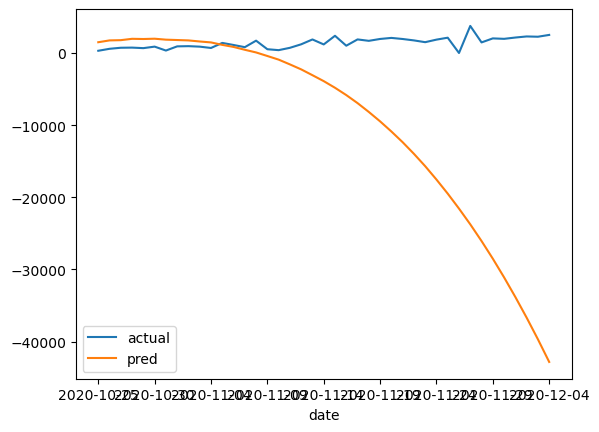

In [84]:
from sklearn.metrics import r2_score

model =auto_arima(y=train['incremental_cases'].dropna(),max_q=10,max_Q=10,
                                         max_p=10, max_P=10,d=2).fit(train['incremental_cases'])
pred = model.predict(41)


predictTest = pd.DataFrame(pred)
predictTest.columns=['incremental_cases']

foo = pd.DataFrame(model.fittedvalues(), columns=['incremental_cases'])
foo.iloc[1,0] = diffDf.diff().iloc[1,0]
foo = foo.cumsum()
firstVal = foo.iloc[-1,0].copy()

foo.iloc[0,0] = diffDf.iloc[0,0]
foo = foo.cumsum()
secondVal = foo.iloc[-1,0].copy()



fooooo = predictTest.copy()
finalIncrementPreds = fromTestDiffToActualInc(fooooo, firstVal, secondVal)



r2 = r2_score(miami.iloc[split:, :].incremental_cases, finalIncrementPreds)
print(r2)

prediction = pd.DataFrame({'actual':miami.iloc[split:, :].incremental_cases.reset_index(drop = True), 
              'pred':finalIncrementPreds.incremental_cases.reset_index(drop = True)})
prediction['date'] = test.index
prediction.plot(x = 'date', y = ['actual', 'pred'])

<AxesSubplot:xlabel='date'>

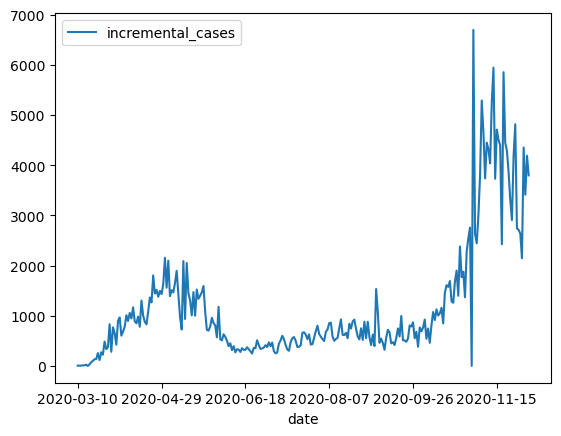

In [57]:
# get selected counties
chicago = df[df.entity == 'Illinois-Cook']
chicago = chicago[['date', 'incremental_cases']]
#miami.reset_index(inplace=True)
chicago.plot(x='date', y='incremental_cases')


In [85]:
diffDf = chicago.set_index('date')

#need to differentiate twice to not be stationary
statDF = diffDf.diff()
firstVal = diffDf.iloc[0,:].incremental_cases
split = int(0.85 * len(statDF))
train = statDF.iloc[:split,:]
test = statDF.iloc[split:, :]
compareTest = diffDf.iloc[split:, :]

In [86]:
def fromTestDiffToActualInc(test, firstVal):
    test.iloc[0,0] += firstVal
    return test.cumsum()

In [71]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index()
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [1,5,10]
q_values = [1,5,10]

P_values = [1,5,10]
Q_values = [1,5,10]


best_score, best_cfg = float("inf"), None

for p in p_values:
    for q in q_values:
        for P in P_values:
            for Q in Q_values:
                order = (p, q, P, Q)
                print(order)
                avg = 0
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]

                    try:
                        model=auto_arima(y=train_data['incremental_cases'],max_q=q,max_Q=Q,
                                         max_p=p, max_P=P,d=2).fit(train_data['incremental_cases'])
                    except:
                        continue

                    forecast = model.predict(val_data.shape[0])
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    avg += mse
                if avg < best_score:
                    best_score, best_cfg = mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')


(1, 1, 1, 1)
(1, 1, 1, 5)
(1, 1, 1, 10)
(1, 1, 5, 1)
(1, 1, 5, 5)
(1, 1, 5, 10)
(1, 1, 10, 1)
(1, 1, 10, 5)
(1, 1, 10, 10)
(1, 5, 1, 1)
(1, 5, 1, 5)
(1, 5, 1, 10)
(1, 5, 5, 1)
(1, 5, 5, 5)
(1, 5, 5, 10)
(1, 5, 10, 1)
(1, 5, 10, 5)
(1, 5, 10, 10)
(1, 10, 1, 1)
(1, 10, 1, 5)
(1, 10, 1, 10)
(1, 10, 5, 1)
(1, 10, 5, 5)
(1, 10, 5, 10)
(1, 10, 10, 1)
(1, 10, 10, 5)
(1, 10, 10, 10)
(5, 1, 1, 1)
(5, 1, 1, 5)
(5, 1, 1, 10)
(5, 1, 5, 1)
(5, 1, 5, 5)
(5, 1, 5, 10)
(5, 1, 10, 1)
(5, 1, 10, 5)
(5, 1, 10, 10)
(5, 5, 1, 1)
(5, 5, 1, 5)
(5, 5, 1, 10)
(5, 5, 5, 1)
(5, 5, 5, 5)
(5, 5, 5, 10)
(5, 5, 10, 1)
(5, 5, 10, 5)
(5, 5, 10, 10)
(5, 10, 1, 1)
(5, 10, 1, 5)
(5, 10, 1, 10)
(5, 10, 5, 1)
(5, 10, 5, 5)
(5, 10, 5, 10)
(5, 10, 10, 1)
(5, 10, 10, 5)
(5, 10, 10, 10)
(10, 1, 1, 1)
(10, 1, 1, 5)
(10, 1, 1, 10)
(10, 1, 5, 1)
(10, 1, 5, 5)
(10, 1, 5, 10)
(10, 1, 10, 1)
(10, 1, 10, 5)
(10, 1, 10, 10)
(10, 5, 1, 1)
(10, 5, 1, 5)
(10, 5, 1, 10)
(10, 5, 5, 1)
(10, 5, 5, 5)
(10, 5, 5, 10)
(10, 5, 10, 1)
(10, 5, 10,

-4.6345051435257085


<AxesSubplot:xlabel='date'>

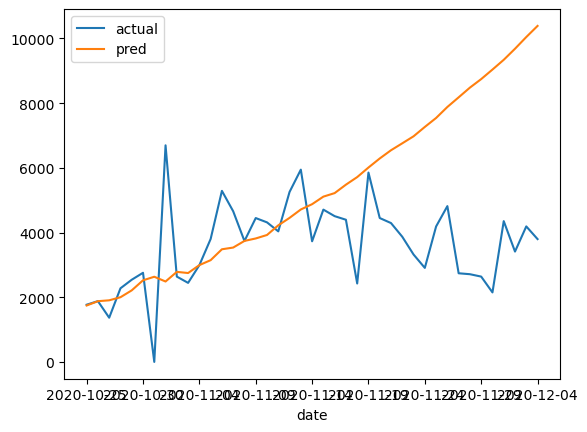

In [87]:
model = auto_arima(y=train['incremental_cases'].dropna(),max_q=10,max_Q=10,
                                         max_p=10, max_P=10,d=2).fit(train['incremental_cases'])
                   
pred = model.predict(41)


predictTest = pd.DataFrame(pred)
predictTest.columns=['incremental_cases']

foo = pd.DataFrame(model.fittedvalues(), columns=['incremental_cases'])

foo.iloc[0,0] = diffDf.iloc[0,0]
foo = foo.cumsum()

firstVal = foo.iloc[-1,0].copy()

fooooo = predictTest.copy()
finalIncrementPreds = fromTestDiffToActualInc(fooooo, firstVal)



r2 = r2_score(chicago.iloc[split:, :].incremental_cases, finalIncrementPreds)
print(r2)

prediction = pd.DataFrame({'actual':chicago.iloc[split:, :].incremental_cases.reset_index(drop = True), 
              'pred':finalIncrementPreds.incremental_cases.reset_index(drop = True)})
prediction['date'] = test.index
prediction.plot(x = 'date', y = ['actual', 'pred'])